In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import VNNGP, SVGP, GaussianLikelihood

/tmp/ipykernel_3677709/2937773115.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
N = 500
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))

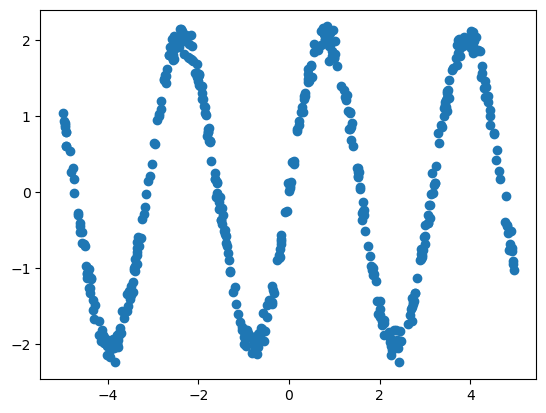

In [3]:
plt.scatter(X, y)

In [4]:
M = 30
kernel = RBF(sigma=1.0, lengthscale=2.0)
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
gp.Z = nn.Parameter(5.0*torch.randn((M, 1))) #choose inducing points
model = GaussianLikelihood(gp)

In [5]:
X_train = X[:, None]
y_train = y

In [6]:
optimizer = optim.Adam(params= model.parameters(), lr=1e-3)


In [7]:
def fit(model, X, y, optimizer, epochs=1000, E=20):
    losses = []
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print("finished Training")
    return losses

In [18]:
losses = fit(model, X_train, y_train, optimizer, epochs=10000, E=20)

  0%|          | 0/10000 [00:00<?, ?it/s]

finished Training


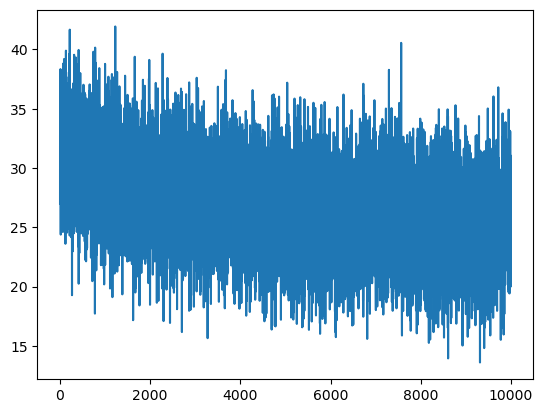

In [19]:
plt.plot(losses)

In [20]:
X_test = torch.linspace(-5, 5, 100)

In [21]:
qF, _, _ = model.gp(X_test[:, None])

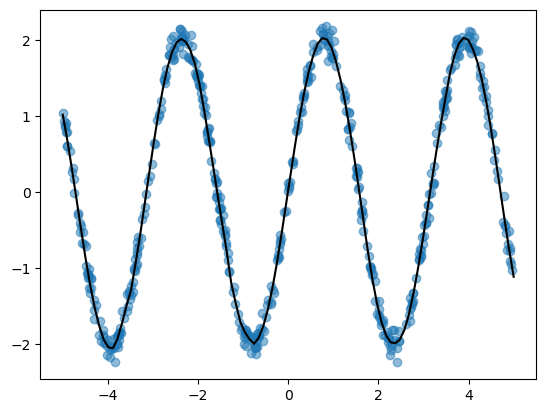

In [22]:
plt.plot(X_test, qF.mean.detach(), color='black')
plt.scatter(X, y, alpha=0.5)